## Modeling

For the model, I will use Temporal Fusion Transformer from PyTorchForecasting library. This library yields several class and methods to facilitate the work with TimeSeries with excellents results.
Initially, I will use TimeSeriesDataset to create a PyTorch dataset (my TimeSeries) and then use DataLoaders to create batches to  fit the model.</br>
More information about this model can be found: 
[Temporal Fusion Transformer ](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html)

In [44]:
import pandas as pd
import pickle
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, MAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [45]:
# Load final preprocessed Dataset
data = pd.read_csv('./output/dataset.csv')

# Convert to Category applicable features
data.item_code = data.item_code.astype(str).astype("category")
data.group_ids = data.group_ids.astype(str).astype("category")
data.month = data.month.astype(str).astype("category")

# from sklearn.preprocessing import MinMaxScaler
# # Normalization of 'quantity'
# scaler = MinMaxScaler()
# data['min_temp_scaled'] = scaler.fit_transform(np.array(data.min_temp).reshape(-1,1))
# data['max_temp_scaled'] = scaler.fit_transform(np.array(data.max_temp).reshape(-1,1))
# data['avg_price_scaled'] = scaler.fit_transform(np.array(data.avg_price).reshape(-1,1))
# data['log_quantity_scaled'] = scaler.fit_transform(np.array(data.avg_price).reshape(-1,1))
data.head()

,item_code,quantity,avg_price,date,min_temp,max_temp,log_quantity,month,sma4,time_idx,group_ids
0,20209,168.0,6.990000,2017-12-01,36.0,84.0,5.123964,12,NaN,0,1
1,50215,453.0,9.898158,2017-12-01,36.0,84.0,6.115892,12,NaN,0,3
2,70165,808.0,9.823333,2017-12-01,36.0,84.0,6.694562,12,NaN,0,2
3,70208,664.0,10.666764,2017-12-01,36.0,84.0,6.498282,12,NaN,0,4
4,70270,56.0,3.250000,2017-12-01,36.0,84.0,4.025352,12,NaN,0,0


In [56]:
# Create Dataset and Dataloaders
max_encoder_length = 30
max_prediction_length = 5
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],    
    time_idx="time_idx",
    target="quantity",
    group_ids=["item_code"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['item_code'],
    time_varying_known_categoricals=['month'],
    time_varying_known_reals=['time_idx', 'avg_price'],
    time_varying_unknown_reals=['quantity','min_temp','max_temp','log_quantity'],
    target_normalizer=GroupNormalizer(groups=['item_code'], transformation="softplus")
)

# validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [140]:
training.decoded_index

,item_code,time_idx_first,time_idx_last,time_idx_first_prediction
0,20209,0,34,30
1,50215,0,34,30
2,70165,0,34,30
3,70208,0,34,30
4,70270,0,34,30
5,70271,0,34,30


## Create Baseline Model as a simple Benchmark
Evaluating a Baseline model using validation dataset to predict last 3 months in each time series


In [95]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
print('MAE (Mean Absolute Error): {}'.format(MAE()(baseline_predictions, actuals)))

MAE (Mean Absolute Error): 136.10000610351562


## Finding Optimal Hyperparameters
Before training the model, I will use "optimize_hyperparameters" to get some clue where to start with hyperparameters identify an optimal learning rate.

In [60]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=150,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.5),
    dropout_range=(0.1, 0.5),
    trainer_kwargs=dict(limit_train_batches=50),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2021-05-04 07:42:10,813] A new study created in memory with name: no-name-4d6d600c-0b04-470a-8e25-572650710efc
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[I 2021-05-04 07:42:26,729] Trial 0 finished with value: 46.905921936035156 and parameters: {'gradient_clip_val': 0.12309854416483279, 'hidden_size': 45, 'dropout': 0.49552171518147603, 'hidden_continuous_size': 14, 'attention_head_size': 4, 'learning_rate': 0.14696216988988609}. Best is trial 0 with value: 46.905921936035156.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[I 2021-05-04 07:42:44,091] Trial 1 finished with value: 66.85167694091797 and parameters: {'gradient_clip_val': 0.06114867556016628, 'hidden_size': 34, 'dropout': 0.31175059667351457, 'hidden_continuous_size': 21, 'attention_head_size': 4, 'learning_rate': 0.002245212915973904}. Best is trial 0 with value: 46.905921936035156.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[I 

{'gradient_clip_val': 0.5371542970613482, 'hidden_size': 12, 'dropout': 0.12521413130996406, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.33432615215581574}


## Training Model

The model I will use is Temporal Fusion Transformer which has beaten algorithms like DeepAR by more than 30%, and also allow us modelling using covariates. Moreover, this model has shown very good result with short time series.

In [61]:
# Training the model (TemporalFusionTransformer)
# {'gradient_clip_val': 0.5371542970613482, 'hidden_size': 12, 'dropout': 0.12521413130996406,
#  'hidden_continuous_size': 8,
#  'attention_head_size': 2, 'learning_rate': 0.33432615215581574}
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(max_epochs=50,
                     min_epochs=10,
                     check_val_every_n_epoch=1,
                     gpus=0,
                     weights_summary="top",
                     gradient_clip_val=0.53,
#                      limit_train_batches= 200,  # coment in for training, running valiation every 30 batches
                     # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
                     callbacks=[lr_logger, early_stop_callback],
                     logger=logger
                    )


tft_model = TemporalFusionTransformer.from_dataset(training,
                                                   learning_rate=0.33,
                                                   hidden_size=12,
                                                   attention_head_size=2,
                                                   dropout=0.12,
                                                   hidden_continuous_size=8,
                                                   #     output_size=7,  # 7 quantiles by default
                                                   loss=MAE(),
                                                   #     loss=
                                                   log_interval=1,
                                                   reduce_on_plateau_patience=4
                                                  )
print(f"Number of parameters in network: {tft_model.size()/1e3:.1f}k")

# Fit the model
trainer.fit(tft_model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 12.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 96    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 36    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 648   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 648   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 648 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [65]:
# Model Evaluation
# Select best model according to loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [66]:
# calcualte mean absolute error on validation dataset
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(127.9918)

In [67]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft_model.predict(val_dataloader, mode="raw", return_x=True)

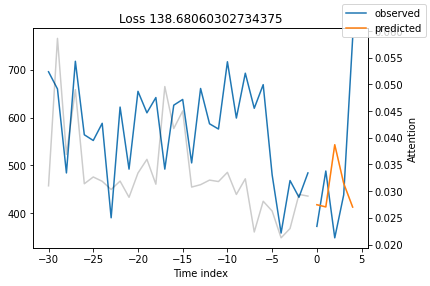

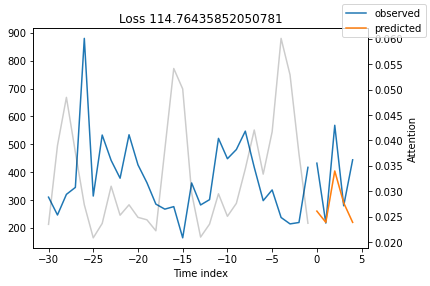

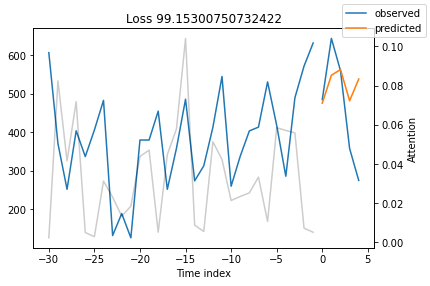

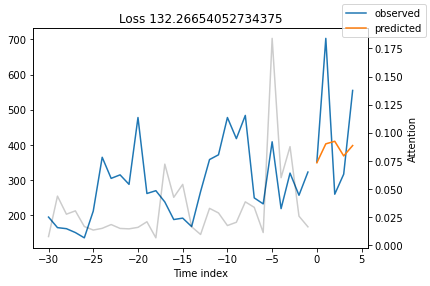

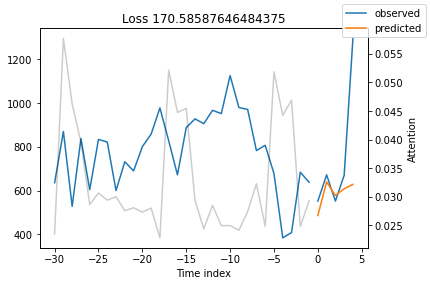

In [68]:
for idx in range(5):  # plot 10 examples
    best_tft_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

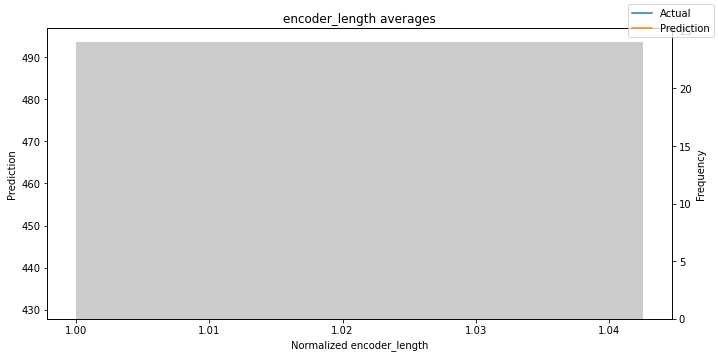

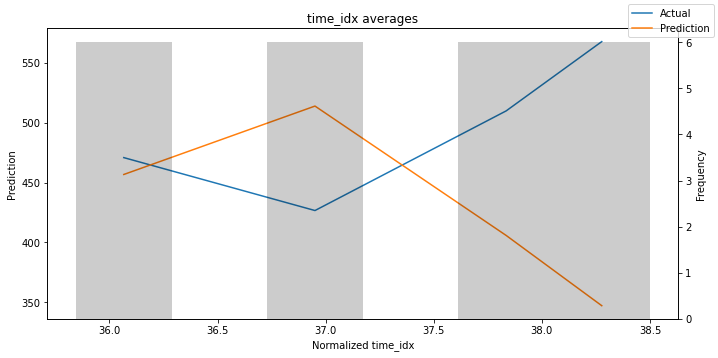

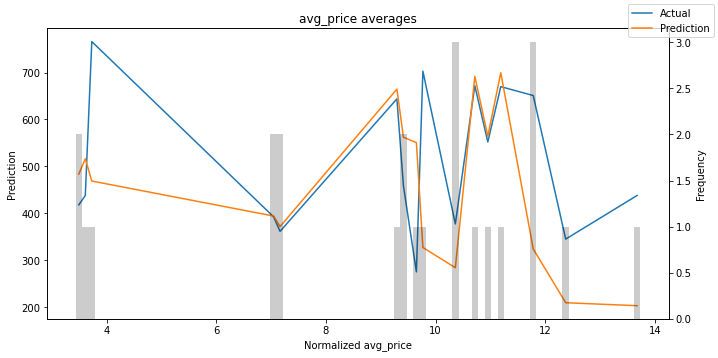

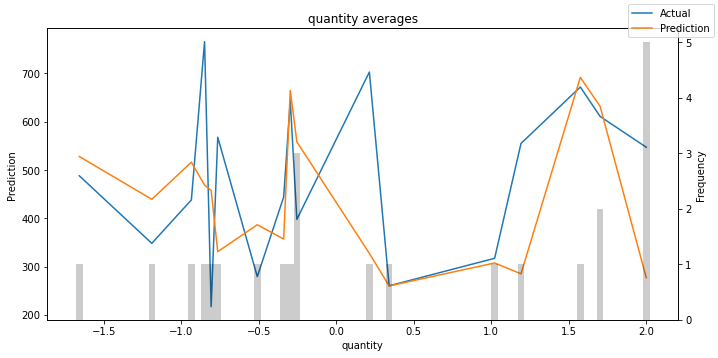

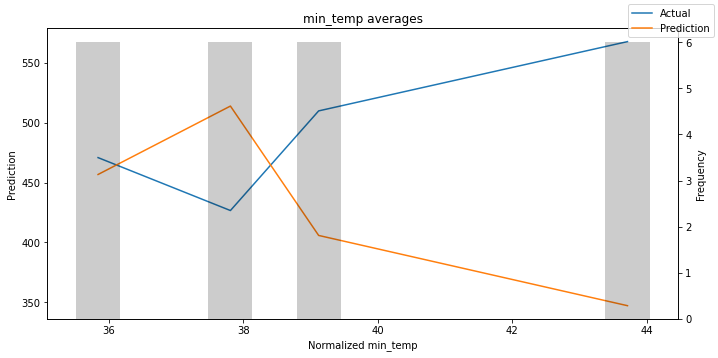

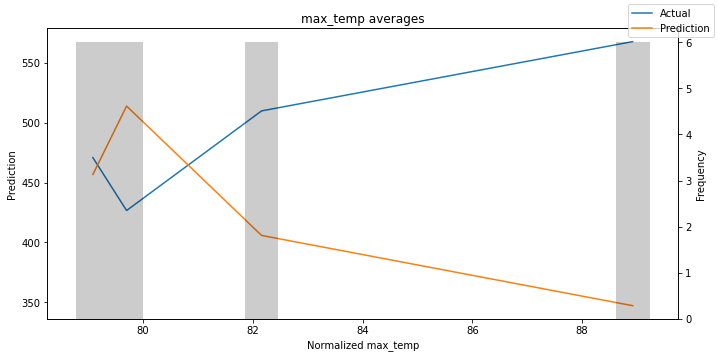

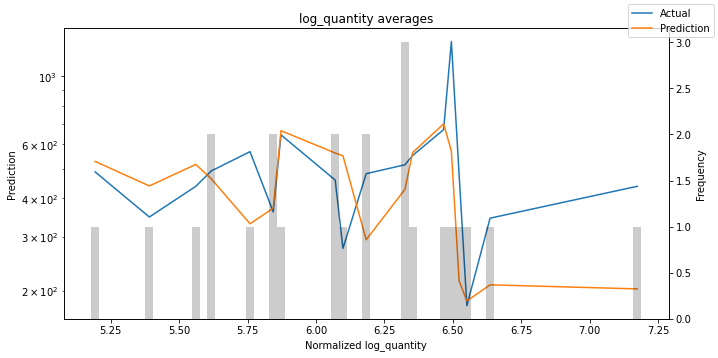

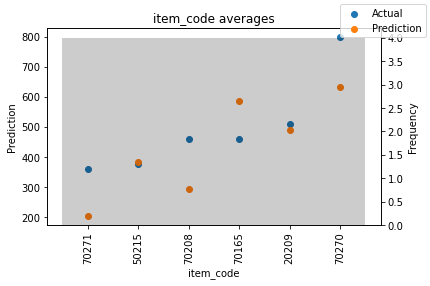

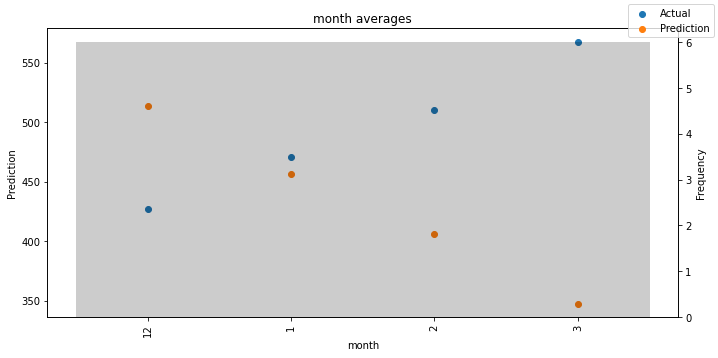

In [43]:
predictions, x = best_tft_model.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft_model.calculate_prediction_actual_by_variable(x, predictions)
best_tft_model.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x162 with 1 Axes>,
 'encoder_variables': <Figure size 504x270 with 1 Axes>,
 'decoder_variables': <Figure size 504x198 with 1 Axes>}

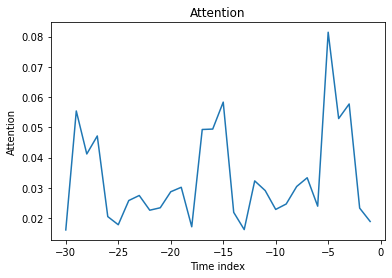

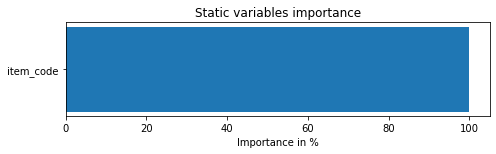

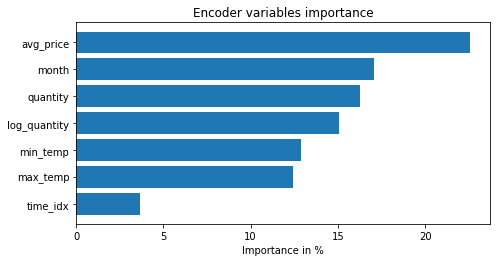

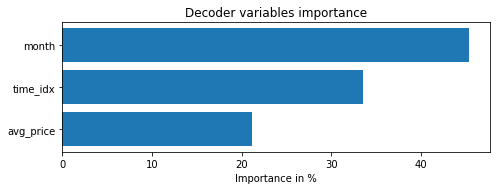

In [69]:
interpretation = best_tft_model.interpret_output(raw_predictions, reduction="sum")
best_tft_model.plot_interpretation(interpretation)

In [108]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [137]:
# Predict on Select data
raw_prediction, x = best_tft_model.predict(
    training.filter(lambda x: (x.item_code == "70165") & (x.time_idx_first_prediction == 31)),
    mode="raw",
    return_x=True,
)

pred = raw_prediction['prediction'].reshape(-1)
actual = x['decoder_target'].reshape(-1)
# actual = data[data.item_code=='70165'][-5:].quantity
print(f'Predictions: {pred}\n Actual:{actual}')
print('MAE (Mean Absolute Error): {}'.format(mean_absolute_error(pred, actual)))

ValueError: After applying filter no sub-sequences left in dataset

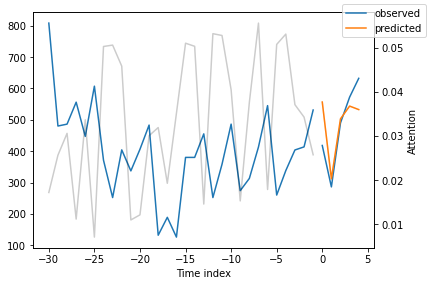

In [112]:
best_tft_model.plot_prediction(x, raw_prediction, idx=0);
decoder_target': tensor([[418., 286., 490., 572., 632.]]),

In [ ]:
                '70270':'Le Contesse Prosechino',
                '20209':'Alverdi, Pinot Grigio',
                '70165':'Santome, Prosecco Extra Dry',
                '50215':'Carpineto, Dogajolo Rosso',
                '70208':'Italo Cescon, Pinot Grigio',
                '70271':'Le Contesse, Pinot Noir Rose Brut'

In [122]:
data[data.item_code=='70165']

,item_code,quantity,avg_price,date,min_temp,max_temp,log_quantity,month,sma4,time_idx,group_ids
2,70165,808.00000,9.823333,2017-12-01,36.0,84.0,6.694562,12,NaN,0,2
8,70165,480.00000,9.847142,2018-01-01,40.0,83.0,6.173786,1,NaN,1,2
14,70165,486.00000,9.748620,2018-02-01,39.0,84.0,6.186209,2,NaN,2,2
20,70165,556.00000,9.690000,2018-03-01,44.0,92.0,6.320768,3,582.500000,3,2
26,70165,447.00000,9.694074,2018-04-01,54.0,100.0,6.102559,4,492.250000,4,2
32,70165,607.00000,9.153250,2018-05-01,58.0,106.0,6.408529,5,524.000000,5,2
38,70165,371.00000,9.383214,2018-06-01,73.0,111.0,5.916202,6,495.250000,6,2
44,70165,252.00000,9.878889,2018-07-01,74.0,116.0,5.529429,7,419.250000,7,2
50,70165,404.00000,9.456552,2018-08-01,72.0,114.0,6.001415,8,408.500000,8,2
56,70165,337.00000,9.740000,2018-09-01,73.0,109.0,5.820083,9,341.000000,9,2
